<a href="https://www.kaggle.com/code/patimejia/insights-dnn-diagnostics-activations-gradients?scriptVersionId=138030277" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

---

> **GOAL**: This code is designed for analysis of deep neural networks. Through visualizing activations, weights, and gradients, we identify issues stemming from activation functions. Much like the length of a pendulum determines its swing frequency, (i.e. $\frac{1}{t_{j-i}}$ hertz), activation functions shape a network's reaction to data.

---
# Deep Neural Networks: Addressing the Gradient Problem

Deep neural networks are powerful tools in machine learning. However, training them can present challenges. One notable challenge is the vanishing and exploding gradient problem during backpropagation. The choice of activation functions can significantly influence these issues.

## Activation Functions

Activation functions introduce non-linearity into the network, enabling it to learn from the error and make adjustments, which is essential for learning complex patterns.

### 1. Sigmoid
 $$f(x) = \frac{1}{1 + e^{-x}} $$
- **Range**: [0, 1]
- **Challenge**: Can lead to vanishing gradients in deep networks due to its saturation for large positive or negative inputs.
- **Gradient**: 
 $\frac{\partial f(x)}{\partial x} = f(x)(1 - f(x)) $

### 2. ReLU (Rectified Linear Unit)
$$ f(x) = \max(0, x) $$
- **Range**: $[0, \infty)$
- **Benefit**: Mitigates the vanishing gradient problem.
- **Challenge**: Can lead to exploding gradients if not carefully initialized or regularized.

### 3. Leaky ReLU
$$f(x) = 
\begin{cases} 
x & \text{if } x > 0 \\
\alpha x & \text{otherwise}
\end{cases} 
$$
- **Range**: $(- \infty, \infty)$
- **Benefit**: Addresses the "dying ReLU" problem where neurons never activate.
- **Parameter**: $\alpha$ is a small positive constant (e.g., $0.01$).

### 4. Tanh
$$ f(x) = \frac{e^x - e^{-x}}{e^x + e^{-x}} $$
- **Range**: $[-1, 1]$
- **Note**: It's a scaled and shifted version of the sigmoid function. In fact, it scales the sigmoid's output by 2 and shifts it down by 1.

### 5. Arctangent
$$ f(x) = \arctan(x) $$
- **Range**: $[- \frac{\pi}{2}, \frac{\pi}{2}]$

## Gradient Dynamics

- **Vanishing Gradient**: Occurs when gradients approach zero, stalling the training process. Often observed with activation functions that squash their inputs into a small range, especially when inputs are large.

- **Exploding Gradient**: Occurs when gradients grow too large, causing divergent behavior. This can be due to deep networks, large parameter values, or particular activation functions.

## Mitigating Strategies

1. **Proper Initialization**: Initialize weights in a manner that neither amplifies nor diminishes gradients during backpropagation.
2. **Shortcuts/Residual connections**: Used in architectures like ResNets, these allow gradients to skip layers and mitigate the vanishing gradient issue.
3. **Gradient Clipping**: A technique to prevent gradients from exceeding a threshold and thus prevent the exploding gradient problem.

## Diagnostic Code

The code provided is a tool designed to help visualize the behavior of different activation functions in deep neural networks. By examining activations, weights, and gradients, we can gain insight into and potentially address the challenges associated with them.

Extracting activations for data: [[ 1. ]
 [ 0.5]
 [-1. ]
 [-0.5]]
Extracting activations for data: [[ 1. ]
 [ 0.5]
 [-1. ]
 [-0.5]]
Extracting activations for data: [[ 1. ]
 [ 0.5]
 [-1. ]
 [-0.5]]
Extracting activations for data: [[ 1. ]
 [ 0.5]
 [-1. ]
 [-0.5]]
Extracting weights from model...
Extracting weights from model...
Extracting weights from model...
Extracting weights from model...
Computing gradients...
Extracting weights from model...
Computing gradients...
Extracting weights from model...
Computing gradients...
Extracting weights from model...
Computing gradients...
Extracting weights from model...
Computing gradients...
Extracting weights from model...
Identifying potential gradient issues...
[Warning] sigmoid has potential vanishing gradient issues at layers: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
Computing gradients...
Extracting weights from model...
Identifying potential gradient issues...
[Warning] relu has potential vanishing gradient issues at layers: [0, 1, 2, 3, 4, 

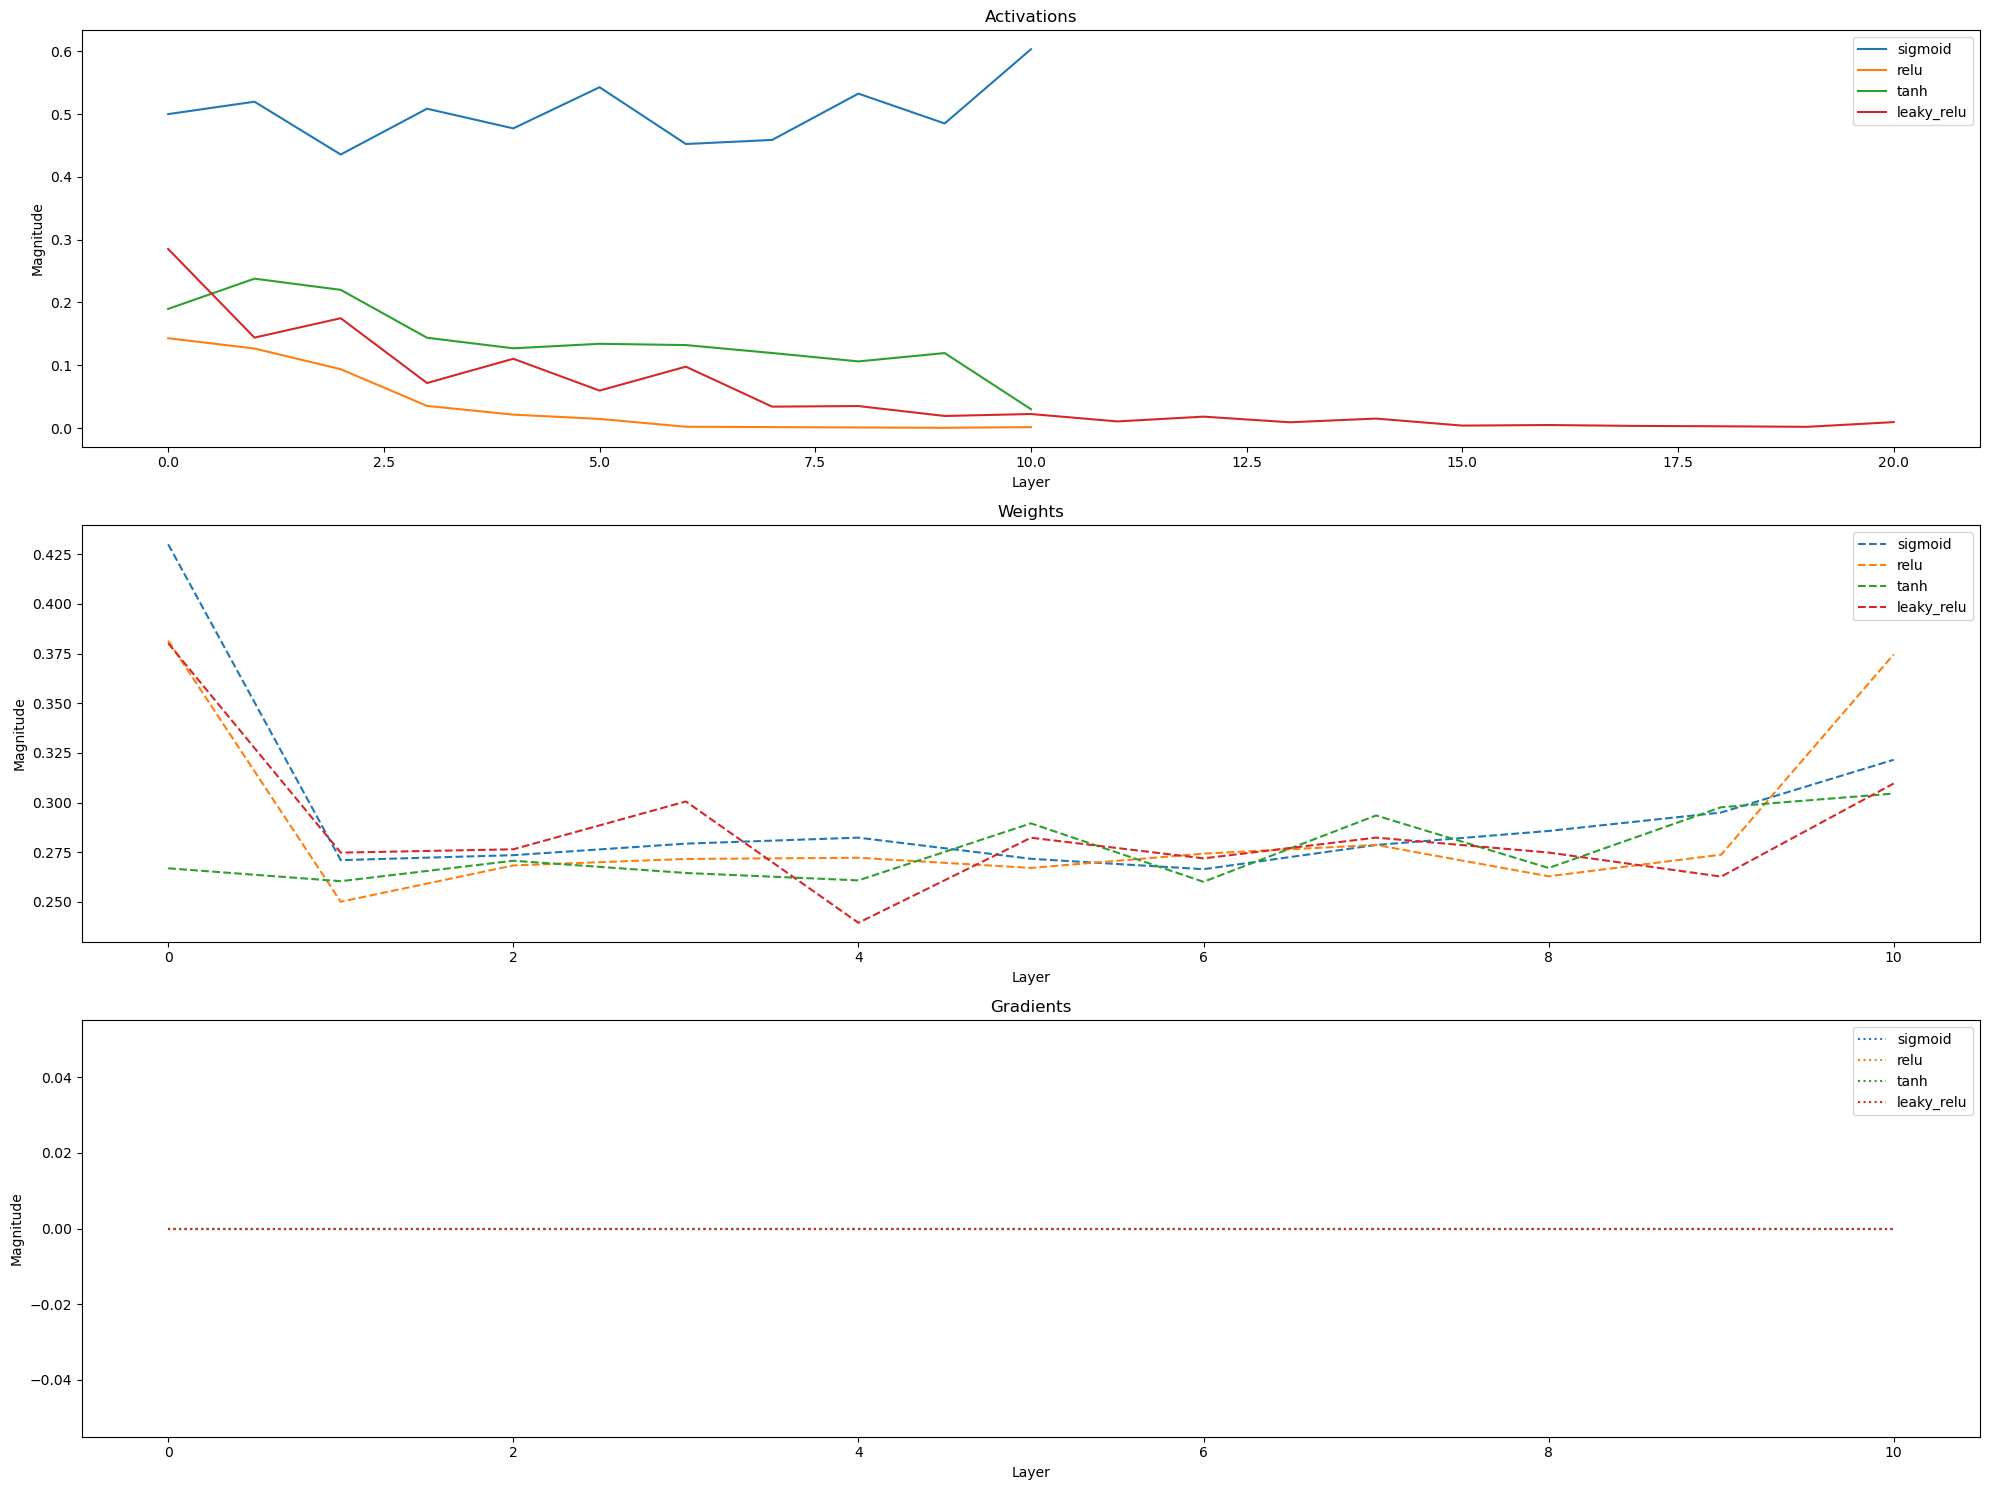

In [4]:
import os
import warnings
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Dense, LeakyReLU

# Suppress TensorFlow logs for clearer output
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
ACTIVATIONS = ['sigmoid', 'relu', 'tanh', 'leaky_relu']

def create_network(activation, layers, units, output_units):
    model = tf.keras.Sequential()
    
    for _ in range(layers):
        if activation == 'leaky_relu':
            model.add(Dense(units))
            model.add(LeakyReLU(alpha=0.01))
        else:
            model.add(Dense(units, activation=activation))
            
    model.add(Dense(output_units))
    model.build(input_shape=(None, 1))
    return model

def get_activations_for_model(model, data):
    print(f"Extracting activations for data: {data.numpy()}")
    return [tf.keras.Model(inputs=model.input, outputs=layer.output).predict(data, verbose=0) for layer in model.layers]

def get_weights_for_model(model):
    print("Extracting weights from model...")
    return [layer.get_weights()[0] for layer in model.layers if layer.get_weights()]

def compute_gradients(model, data):
    print("Computing gradients...")
    with tf.GradientTape(persistent=True) as tape:
        tape.watch(data)
        predictions = model(data)
    
    gradient_input = tape.gradient(predictions, data).numpy()
    weights_tf = [tf.convert_to_tensor(weight) for weight in get_weights_for_model(model)]
    gradient_weights = [tape.gradient(predictions, weight).numpy() if tape.gradient(predictions, weight) else np.zeros_like(weight.numpy()) for weight in weights_tf]
    del tape
    return gradient_input, gradient_weights

def identify_gradient_issues(gradient_weights):
    print("Identifying potential gradient issues...")
    gradient_issues = {"vanishing": [], "exploding": []}
    for idx, gradient in enumerate(gradient_weights):
        if np.linalg.norm(gradient) < 1e-5:
            gradient_issues["vanishing"].append(idx)
        elif np.linalg.norm(gradient) > 1e3:
            gradient_issues["exploding"].append(idx)
    return gradient_issues

def plot_function(data, label, title, linestyle='-'):
    avg_magnitudes = [np.mean(np.abs(d)) for d in data]
    plt.plot(avg_magnitudes, label=label, linestyle=linestyle)


def plot_diagnostics(models, data):
    plt.figure(figsize=(20, 15))
    diagnostics = [("Activations", '-'), ("Weights", '--'), ("Gradients", ':')]
    
    for idx, (title, linestyle) in enumerate(diagnostics, 1):
        plt.subplot(3, 1, idx)
        for activation_type, model in models.items():
            if title == "Activations":
                data_to_plot = get_activations_for_model(model, data)
            elif title == "Weights":
                data_to_plot = get_weights_for_model(model)
            else:
                _, gradient_weights = compute_gradients(model, data)
                data_to_plot = gradient_weights
            
            plot_function(data_to_plot, activation_type, title, linestyle)
        
        plt.xlabel('Layer')
        plt.ylabel('Magnitude')
        plt.title(title)
        plt.legend()
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            plt.tight_layout()
    
    for activation_type, model in models.items():
        _, gradient_weights = compute_gradients(model, data)
        gradient_issues = identify_gradient_issues(gradient_weights)
        if gradient_issues["vanishing"]:
            print(f"[Warning] {activation_type} has potential vanishing gradient issues at layers: {gradient_issues['vanishing']}")
        if gradient_issues["exploding"]:
            print(f"[Warning] {activation_type} has potential exploding gradient issues at layers: {gradient_issues['exploding']}")
    
    plt.show()

models_dict = {activation: create_network(activation, 10, 10, 1) for activation in ACTIVATIONS}
data_batch = tf.constant([[1.0], [0.5], [-1.0], [-0.5]])
plot_diagnostics(models_dict, data_batch)

# Leaky ReLU: A Closer Look

Why might Leaky ReLU exhibit distinct behavior?

- **No Zero Slope**: Unlike standard ReLU, Leaky ReLU retains a small gradient for negative inputs. This prevents 'dead neurons' – neurons that never activate.
  
- **Deep Networks**: Activation functions' effects intensify in deep networks. For sigmoid, gradients can vanish in deep layers due to minuscule gradient values. Standard ReLU's gradients can vanish for negative inputs or stay consistent for positive ones. However, Leaky ReLU's gradient remains slightly positive for negative inputs. In deeper layers, these minute gradients can compound, resulting in significant activations.

- **Initialization**: The manner in which weights and biases are initialized can sway activation behaviors. If initial conditions push Leaky ReLU's activations mostly towards negative values, growing network depth might amplify these activations, especially if negative values consistently pass through Leaky ReLU.

- **Network Design**: The overall architecture, encompassing neuron count, layer structure, and inter-neuronal connections, can modulate activation behaviors. Certain designs might amplify or suppress activations.

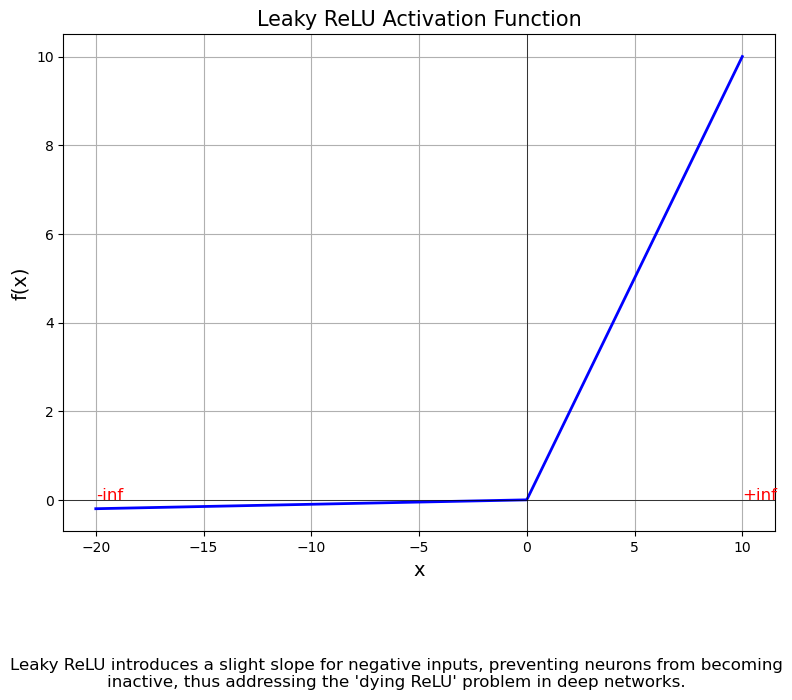

In [9]:
import numpy as np
import matplotlib.pyplot as plt

def leaky_relu(x, alpha=0.01):
    return np.where(x > 0, x, alpha * x)

# Define x range with more emphasis towards negative values
x = np.linspace(-20, 10, 600)

# Compute Leaky ReLU values
y = leaky_relu(x)

# Plotting
plt.figure(figsize=(8, 6))
plt.plot(x, y, 'b-', linewidth=2)
plt.title('Leaky ReLU Activation Function', fontsize=15)
plt.xlabel('x', fontsize=14)
plt.ylabel('f(x)', fontsize=14)
plt.grid(True)
plt.axhline(0, color='black',linewidth=0.5)
plt.axvline(0, color='black',linewidth=0.5)
plt.annotate('-inf', xy=(-20, 0), xycoords='data', textcoords='data', color='red', fontsize=12)
plt.annotate('+inf', xy=(10, 0), xycoords='data', textcoords='data', color='red', fontsize=12)

# Adding caption below the plot
caption = "Leaky ReLU introduces a slight slope for negative inputs, preventing neurons from becoming inactive, thus addressing the 'dying ReLU' problem in deep networks."
plt.figtext(0.5, -0.15, caption, wrap=True, horizontalalignment='center', fontsize=12)

plt.tight_layout()
plt.show()